<font color='tomato'><font color="#CC3D3D"><p>
# AutoRec
     # 참고: https://github.com/supkoon/AutoRec-tf/blob/master/AutoRec.py
             https://changiusk.github.io/papers/autorec

##### Model architecture:
<img align='left' src='/Users/kimminsu/Desktop/AI,BIGDATA CLASS/Recommender System/image/autorec_architecture.png' width=700>

##### Loss:
<img align='left' src='/Users/kimminsu/Desktop/AI,BIGDATA CLASS/Recommender System/image/autorec_loss.png' width=500>

### Import modules

In [4]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from zipfile import ZipFile
from pathlib import Path
import pickle, random, os

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.18.0


### Global settings

In [5]:
# 하이퍼파라미터 설정

kind = 'I'             # I-AutoRec
dimension = 50         # number of nodes in bottleneck hidden layer
test_size = 0.2        # test_proportion of datasets
epochs = 500
batch_size = 512
reg = 0.0005           # regularization for encoder & decoder
learner = 'rmsprop'       # optimizer
learning_rate = 0.0001    
patience = 10          # earlystopping patience

### Step 1: Load and process the data

##### Get data

In [12]:
movielens_data_file_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
movielens_zipped_file = tf.keras.utils.get_file(
    "/Users/kimminsu/Desktop/AI,BIGDATA CLASS/Recommender System/data", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r")as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

RecursionError: maximum recursion depth exceeded

In [10]:
import sys
sys.setrecursionlimit(1500)  # 기본값보다 높은 값으로 설정

##### Load data

In [8]:
class dataloader():
    # (args) test_size: 테스트 세트 비율
    def __init__(self, test_size, path = movielens_dir / "ratings.csv"):
        self.test_size = test_size
        self.ratings_df = pd.read_csv(path)
        self.ratings_df.columns = ["userId","movieId","rating","timestamp"]
        self.num_user = len(self.ratings_df.userId.unique())
        self.num_item = len(self.ratings_df.movieId.unique())
        
    # for U-AutoRec
    def make_user_autorec_input(self):
        user_item_df = self.ratings_df.pivot_table(index="userId", columns="movieId", values="rating")
        user_item_df.fillna(0,inplace=True)
        user_item_df = np.array(user_item_df)
        train_df, test_df = train_test_split(user_item_df, test_size =self.test_size)
        return train_df, test_df

    # for I-AutoRec
    def make_item_autorec_input(self):
        item_user_df = self.ratings_df.pivot_table(index="movieId", columns="userId", values="rating")
        item_user_df.fillna(0,inplace=True)
        item_user_df = np.array(item_user_df)
        train_df, test_df = train_test_split(item_user_df, test_size =self.test_size)
        return train_df, test_df

NameError: name 'movielens_dir' is not defined

In [5]:
dataloader = dataloader(test_size)
if kind == 'U': # for U-AutoRec
    train_data, test_data = dataloader.make_user_autorec_input()
    num_features = dataloader.num_item
else:           # for I-AutoRec
    train_data, test_data = dataloader.make_item_autorec_input()
    num_features = dataloader.num_user

print(num_features)    

610


### Step 2: Define the model architecture

##### Stack layers from input to output

In [6]:
input_layer = x = keras.Input(shape=(num_features,), name='UserRating')
x = keras.layers.Dense(dimension, activation='relu', kernel_regularizer=keras.regularizers.L2(reg), name='LatentSpace')(x)
output_layer = keras.layers.Dense(num_features, activation='linear', kernel_regularizer=keras.regularizers.L2(reg), name='UserScorePred')(x)
model = keras.Model(input_layer, output_layer)

##### Summarize & visualize the model

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 610)]             0         
                                                                 
 LatentSpace (Dense)         (None, 50)                30550     
                                                                 
 UserScorePred (Dense)       (None, 610)               31110     
                                                                 
Total params: 61660 (240.86 KB)
Trainable params: 61660 (240.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


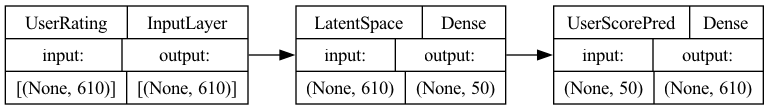

In [8]:
# 연결 그래프 시각화
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Step 3: Choose the optimizer and the loss function

##### Define customized loss & metrics

In [9]:
def masked_mse_loss(y_true, y_pred):
    # 마스크 : 관측된 데이터에 대해서는 1, 관측되지 않은데이터는 0
    mask = y_true != 0 
    #기존에 관측되지 않았던 결과에 대해서는 마스킹을 진행하여 Loss 계산
    mask_float = tf.cast(mask, tf.float32)
    masked_error = tf.reduce_mean(tf.pow(tf.subtract(mask_float * y_pred,y_true),2))
    return masked_error

def masked_rmse_clip(y_true, y_pred):
    mask = y_true != 0 
    # 예측값이 1 ~ 5가 되도록 조정
    y_pred = tf.clip_by_value(y_pred, 1, 5)
    mask_float = tf.cast(mask, tf.float32)
    masked_error = tf.reduce_mean(tf.pow(tf.subtract(mask_float * y_pred,y_true),2))
    return tf.sqrt(masked_error)

##### Set optimizer, learning rate, loss & metrics 

In [10]:
# 미리 설정한 옵티마이저와 학습율을 반영하여 compile 수행
if learner.lower() == "adagrad":
    model.compile(optimizer=keras.optimizers.legacy.Adagrad(learning_rate=learning_rate), loss=masked_mse_loss,
                  metrics=[masked_rmse_clip])
elif learner.lower() == "rmsprop":
    model.compile(optimizer=keras.optimizers.legacy.RMSprop(learning_rate=learning_rate), loss=masked_mse_loss,
                  metrics=[masked_rmse_clip])
elif learner.lower() == "adam":
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss=masked_mse_loss,
                  metrics=[masked_rmse_clip])
else:
    model.compile(optimizer=keras.optimizers.legacy.SGD(learning_rate=learning_rate), loss=masked_mse_loss,
                  metrics=[masked_rmse_clip])

### Step 4: Train the model

##### Set learning conditions & fit the model 

In [11]:
early_stopping_callback = keras.callbacks.EarlyStopping(patience=patience,restore_best_weights=True)
hist = model.fit(train_data, train_data, batch_size=batch_size, epochs=epochs, 
                    validation_data=(test_data, test_data), callbacks=[early_stopping_callback])

Epoch 1/500
16/16 [==============================] - 0s 6ms/step - loss: 0.3148 - masked_rmse_clip: 0.3528 - val_loss: 0.3113 - val_masked_rmse_clip: 0.3522
Epoch 2/500
16/16 [==============================] - 0s 3ms/step - loss: 0.3048 - masked_rmse_clip: 0.3551 - val_loss: 0.3023 - val_masked_rmse_clip: 0.3512
Epoch 3/500
16/16 [==============================] - 0s 3ms/step - loss: 0.2955 - masked_rmse_clip: 0.3528 - val_loss: 0.2925 - val_masked_rmse_clip: 0.3493
Epoch 4/500
16/16 [==============================] - 0s 3ms/step - loss: 0.2852 - masked_rmse_clip: 0.3487 - val_loss: 0.2816 - val_masked_rmse_clip: 0.3461
Epoch 5/500
16/16 [==============================] - 0s 3ms/step - loss: 0.2737 - masked_rmse_clip: 0.3415 - val_loss: 0.2693 - val_masked_rmse_clip: 0.3414
Epoch 6/500
16/16 [==============================] - 0s 3ms/step - loss: 0.2609 - masked_rmse_clip: 0.3350 - val_loss: 0.2557 - val_masked_rmse_clip: 0.3349
Epoch 7/500
16/16 [==============================] - 0s 3m

##### Evaluate model

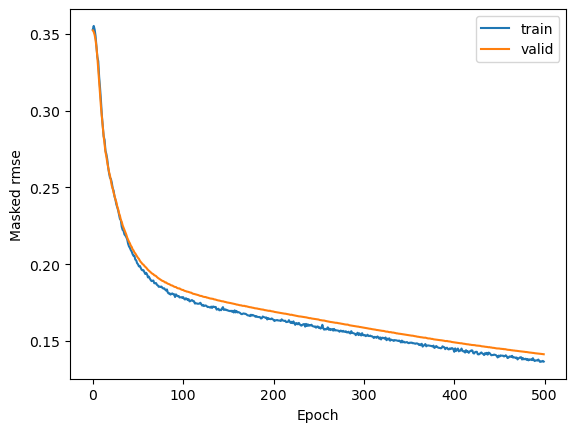

In [12]:
# Plot Learning Curves

plt.plot(hist.history['masked_rmse_clip'], label="train")
plt.plot(hist.history['val_masked_rmse_clip'], label="valid")
plt.xlabel('Epoch')
plt.ylabel('Masked rmse')
plt.legend()
plt.show()

<font color='tomato'><font color="#CC3D3D"><p>
# End